In [2]:
from gensim import corpora, models
import pandas as pd
import pprint, re, spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
from gensim.utils import simple_preprocess

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
articles = pd.read_csv('train.csv')
articles.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
def preprocess_corpus(text):
    # Convert series to list
    text = text.values.tolist()
    # Remove LaTeX equation environments
    text = [re.sub(r'\\begin{equation}\s.*?\s\\end{equation}', '', sent) for sent in text]
    # Remove new line characters
    text = [re.sub('\s+', ' ', sent) for sent in text]
    # Remove inline equations
    sentences = [re.sub(r"\$.*?\$|\$\s.*?\s\$", "", sent) for sent in text]
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

processed_text = list(preprocess_corpus(articles.ABSTRACT))

In [50]:
# Build the bigram and trigram models
bigram = models.Phrases(processed_text, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = models.Phrases(bigram[processed_text], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[processed_text[0]]])

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove stop words from the corpus

text_words_nostops = remove_stopwords(processed_text)

In [10]:
# Create the Bigrams

text_words_bigrams = make_bigrams(text_words_nostops)

In [11]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Perform lemmatization on corpus, keeping only noun, adj, vb, adv
text_lemmatized = lemmatization(text_words_bigrams, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [12]:
print(text_lemmatized[:1])

[['predictive', 'model', 'allow', 'specific', 'inference', 'analyzing', 'disease', 'relate', 'alteration', 'neuroimage', 'datum', 'give', 'datum', 'inference', 'make', 'level', 'global', 'identifiye', 'condition', 'presence', 'local', 'detect', 'condition', 'effect', 'individual', 'measurement', 'extract', 'datum', 'global', 'inference', 'widely_use', 'local', 'inference', 'use', 'form', 'specific', 'effect', 'map', 'rarely', 'use', 'exist', 'model', 'often', 'yield', 'noisy', 'detection', 'compose', 'disperse', 'isolate', 'island', 'article', 'propose', 'reconstruction', 'method', 'name', 'improve', 'specific', 'detection', 'predictive', 'modeling', 'approach', 'particular', 'binary', 'classifier', 'specifically', 'aim', 'reduce', 'noise', 'due', 'sample', 'error', 'associate', 'use', 'finite', 'sample', 'train', 'classifier', 'propose', 'method', 'wrapper', 'type', 'use', 'different', 'binary', 'classifier', 'diagnostic', 'manner', 'information', 'condition', 'presence', 'reconstruct

In [30]:
# from gensim.parsing.preprocessing import (preprocess_string, 
#                                           strip_multiple_whitespaces, 
#                                           strip_numeric, 
#                                           strip_punctuation, 
#                                           strip_tags, 
#                                           stem_text, 
#                                           remove_stopwords)

# articles['preprocessed_text'] = articles.ABSTRACT.apply(lambda x: preprocess_string(x, filters=[lambda x: x.lower(), 
#                                                                                                             strip_tags, 
#                                                                                                             strip_punctuation, 
#                                                                                                             strip_multiple_whitespaces, 
#                                                                                                             strip_numeric, 
#                                                                                                             remove_stopwords, 
#                                                                                                             stem_text
#                                                                                                             ]))

# print(articles['ABSTRACT'][3])
# print(articles['preprocessed_text'][3])

In [14]:
dictionary = corpora.Dictionary(text_lemmatized)

bow_corpus = [dictionary.doc2bow(text) for text in text_lemmatized]

In [15]:
print(dictionary)

Dictionary<35850 unique tokens: ['accuracy', 'ad', 'adni', 'aim', 'allow']...>


In [16]:
print(bow_corpus[10])

[(5, 2), (9, 1), (33, 1), (37, 1), (38, 2), (43, 1), (52, 1), (74, 4), (82, 2), (93, 1), (96, 1), (103, 1), (110, 3), (177, 1), (179, 1), (198, 1), (202, 2), (206, 1), (238, 1), (253, 1), (261, 1), (268, 1), (279, 1), (289, 1), (302, 3), (334, 2), (355, 1), (357, 2), (366, 1), (409, 1), (444, 1), (445, 1), (446, 1), (447, 1), (448, 1), (449, 1), (450, 1), (451, 1), (452, 1), (453, 1), (454, 1), (455, 1), (456, 2), (457, 2), (458, 1), (459, 1), (460, 1), (461, 1), (462, 8), (463, 1), (464, 1), (465, 2), (466, 3), (467, 5), (468, 1), (469, 1), (470, 1), (471, 1), (472, 1), (473, 2), (474, 2), (475, 2), (476, 1), (477, 2), (478, 1), (479, 1), (480, 1), (481, 1), (482, 3), (483, 1), (484, 1), (485, 5), (486, 3), (487, 1), (488, 2), (489, 3), (490, 1), (491, 1), (492, 1), (493, 1), (494, 1), (495, 1), (496, 1), (497, 1), (498, 1), (499, 1), (500, 1), (501, 2), (502, 5), (503, 1), (504, 1), (505, 1), (506, 1), (507, 4), (508, 1)]


In [31]:
ldamodel = models.ldamodel.LdaModel(bow_corpus, 
                                    num_topics=6, 
                                    id2word=dictionary,
                                    random_state=42,
                                    update_every=1,
                                    chunksize=100,
                                    passes=20,
                                    alpha='auto',
                                    eta='auto',
                                    per_word_topics=True)

pprint.pprint(ldamodel.top_topics(bow_corpus, topn=2))

[([(0.02685883, 'network'), (0.021368546, 'model')], -0.6767291021681513),
 ([(0.01595527, 'problem'), (0.012528186, 'show')], -0.8065970608401349),
 ([(0.016677702, 'system'), (0.00953813, 'time')], -1.272965675796693),
 ([(0.010157273, 'field'), (0.009422208, 'phase')], -2.0900988360872463),
 ([(0.035961505, 'state'), (0.022978736, 'spin')], -2.572556099232736),
 ([(0.026541494, 'equation'), (0.025868205, 'group')], -3.1966961808189676)]


In [33]:
for i in sorted(ldamodel.show_topics()):
    print(i)

(0, '0.016*"problem" + 0.013*"show" + 0.011*"result" + 0.010*"function" + 0.010*"model" + 0.010*"method" + 0.009*"set" + 0.008*"number" + 0.007*"paper" + 0.007*"give"')
(1, '0.017*"system" + 0.010*"time" + 0.009*"model" + 0.009*"use" + 0.008*"datum" + 0.007*"base" + 0.006*"control" + 0.006*"network" + 0.006*"provide" + 0.006*"design"')
(2, '0.036*"state" + 0.023*"spin" + 0.021*"quantum" + 0.017*"lattice" + 0.015*"material" + 0.015*"body" + 0.014*"ground" + 0.013*"electronic" + 0.013*"charge" + 0.012*"interaction"')
(3, '0.010*"field" + 0.009*"phase" + 0.009*"model" + 0.008*"high" + 0.008*"find" + 0.008*"energy" + 0.008*"low" + 0.007*"show" + 0.007*"temperature" + 0.006*"large"')
(4, '0.027*"equation" + 0.026*"group" + 0.019*"space" + 0.017*"prove" + 0.014*"operator" + 0.014*"solution" + 0.012*"boundary" + 0.012*"theory" + 0.010*"flow" + 0.009*"give"')
(5, '0.027*"network" + 0.021*"model" + 0.020*"datum" + 0.018*"method" + 0.017*"learn" + 0.017*"propose" + 0.012*"approach" + 0.012*"use"

In [34]:
from gensim.models import CoherenceModel

# Compute the Perplexity score
print('Perplexity: ', ldamodel.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute the Coherence score
coherence_model_lda = CoherenceModel(model=ldamodel, 
                                     texts=text_lemmatized, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -7.938097854346047

Coherence Score:  0.44032298074742865


In [42]:
def calculate_coherence_score(alpha, beta):
    """
    Function for hyperparameter tuning of alpha and beta parameters.
    """
    # Defining the LDA model
    ldamodel = models.ldamodel.LdaModel(corpus=bow_corpus,
                                         id2word=dictionary,
                                         num_topics=6, 
                                         random_state=42,
                                         update_every=1,
                                         chunksize=100,
                                         passes=20,
                                         alpha=alpha,
                                         per_word_topics=True,
                                         eta=beta)
    # Defining the Coherence model
    coherence_model_lda = CoherenceModel(model=ldamodel, 
                                         texts=text_lemmatized, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    # Obtaining the coherence score
    coherence_lda = coherence_model_lda.get_coherence()
    
    return coherence_lda

In [41]:
# List containing the hyperparameters to be fine-tuned. This code block will take between two and three hours to load depending on your machine

alpha_list = ['symmetric', 'auto', 'asymmetric', 0.3, 0.5, 0.7]
beta_list = ['auto', 0.3, 0.5, 0.7]

for alpha in alpha_list:
    for beta in beta_list:
        coherence_score = calculate_coherence_score(alpha, beta)
        print(f"alpha : {alpha}; beta : {beta}; Score : {coherence_score}")

alpha : symmetric; beta : auto; Score : 0.43537765058176325
alpha : symmetric; beta : 0.3; Score : 0.4369890418395073
alpha : symmetric; beta : 0.5; Score : 0.41684868993319474
alpha : symmetric; beta : 0.7; Score : 0.4176713248015851
alpha : auto; beta : auto; Score : 0.44032298074742865
alpha : auto; beta : 0.3; Score : 0.4447049890247526
alpha : auto; beta : 0.5; Score : 0.425049053391499
alpha : auto; beta : 0.7; Score : 0.4227345192202104
alpha : asymmetric; beta : auto; Score : 0.4301845028477895
alpha : asymmetric; beta : 0.3; Score : 0.41913573641524154
alpha : asymmetric; beta : 0.5; Score : 0.4338918519286527
alpha : asymmetric; beta : 0.7; Score : 0.43192381202975244
alpha : 0.3; beta : auto; Score : 0.4168464439018142
alpha : 0.3; beta : 0.3; Score : 0.45778086282316144
alpha : 0.3; beta : 0.5; Score : 0.4151521349269272
alpha : 0.3; beta : 0.7; Score : 0.41844348414896687
alpha : 0.5; beta : auto; Score : 0.4391195121948524
alpha : 0.5; beta : 0.3; Score : 0.45398699390588

In [43]:
# Retraining the LDA model using optimal parameters
ldamodel = models.ldamodel.LdaModel(bow_corpus, 
                                    num_topics=6, 
                                    id2word=dictionary,
                                    random_state=42,
                                    update_every=1,
                                    chunksize=100,
                                    passes=50,
                                    alpha=0.3,
                                    eta=0.3,
                                    per_word_topics=True)

In [44]:
# Compute the new Perplexity and Coherence scores
print('Perplexity: ', ldamodel.log_perplexity(bow_corpus))

coherence_model_lda = CoherenceModel(model=ldamodel, 
                                     texts=text_lemmatized, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

print('\nCoherence Score: ', coherence_model_lda.get_coherence())

Perplexity:  -7.833737545201825

Coherence Score:  0.4597396315491992


In [45]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.127308  0.039941       1        1  22.484006
1     -0.079832 -0.127607       2        1  21.075635
3     -0.012659 -0.014315       3        1  18.889753
5     -0.133985 -0.131623       4        1  17.255613
4     -0.038739  0.265764       5        1  15.246238
2      0.392523 -0.032160       6        1   5.048755, topic_info=             Term          Freq         Total Category  logprob  loglift
205        system   8667.000000   8667.000000  Default  30.0000  30.0000
102         state   5198.000000   5198.000000  Default  29.0000  29.0000
130       network  10182.000000  10182.000000  Default  28.0000  28.0000
1448        learn   4999.000000   4999.000000  Default  27.0000  27.0000
72         method  10379.000000  10379.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
343       dynamic    667.043907   2795.476036   Topic6  -4.8414   1.5531
212      behavior    461.059424   1554.382098   Topic6  -5.2107   1.7707
400        regime    416.035358   1015.887336   Topic6  -5.3135   2.0933
790   dimensional    450.331409   2473.605069   Topic6  -5.2343   1.2826
74          model    543.829861  17227.424448   Topic6  -5.0456  -0.4696

[412 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.337351  accuracy
0         4  0.661644  accuracy
2867      2  0.829375  activity
2867      3  0.169118  activity
843       5  0.993992     admit
...     ...       ...       ...
380       2  0.282138      work
380       3  0.111618      work
380       4  0.269762      work
380       5  0.135225      work
2604      2  0.994094     world

[663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 6, 5, 3])

In [49]:
# Saving pyLDAvis notebook to file
pyLDAvis.save_html(vis, 'LDA_vis.html')

In [36]:
# # Join the different processed abstracts together.
# long_string = ' '.join(articles['preprocessed_text'].str)

# # Create a WordCloud object and generate wordcloud
# wordcloud = WordCloud(background_color="black",
#                       max_words=1000, 
#                       contour_width=3, 
#                       contour_color='steelblue').generate(long_string)

# # Visualize the word cloud
# plt.figure(figsize=(12, 9))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

In [46]:
topics = ldamodel.show_topics(formatted=False)

In [47]:
import matplotlib.colors as mcolors

cols = [color for _, color in mcolors.TABLEAU_COLORS.items()]

wordcloud = WordCloud(background_color="white",
                      contour_width=3,
                      max_words=20,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

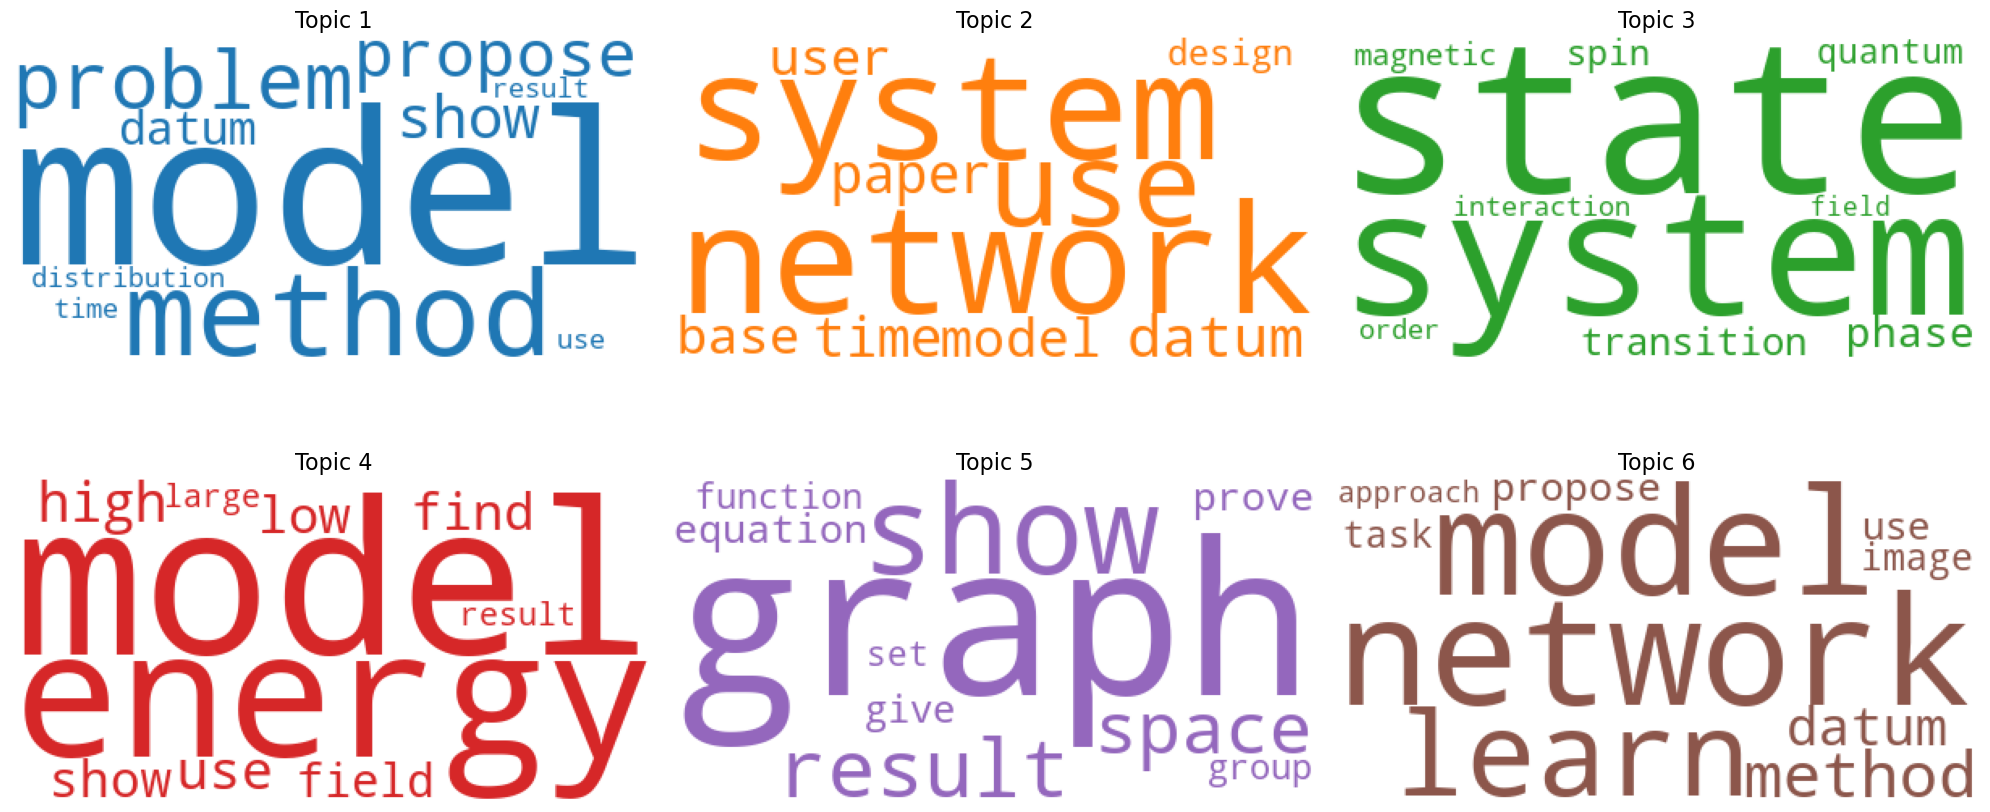

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    wordcloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic '+str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()